<a href="https://colab.research.google.com/github/panyuiting/Demo/blob/master/%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
我想写一个简单的强化学习的代码

NameError: name '我想写一个简单的强化学习的代码' is not defined

### 1. 安装 `gymnasium` 库

首先，我们需要安装 `gymnasium` 库。它提供了许多经典的强化学习环境，例如CartPole、MountainCar等。

In [2]:
import sys
!{sys.executable} -m pip install gymnasium

### 2. 创建并探索一个简单的环境

安装完成后，我们可以创建一个简单的环境，例如 `CartPole-v1`。这个环境的目标是让杆子保持平衡。

基本的交互流程是：
1. `gymnasium.make()`: 创建环境实例。
2. `env.reset()`: 重置环境到初始状态，返回初始观测值和信息。
3. `env.step(action)`: 在环境中执行一个动作，返回新的观测值、奖励、是否结束、是否截断以及额外的信息。
4. `env.close()`: 关闭环境，释放资源。

In [3]:
import gymnasium as gym

# 创建一个 CartPole-v1 环境
env = gym.make('CartPole-v1', render_mode='human') # render_mode='human' 可以显示图形界面，但在Colab中可能不直接支持，通常设为None或'rgb_array'

# 重置环境，获取初始观测值和信息
observation, info = env.reset()

# 运行一个简单的循环，随机选择动作
for _ in range(100):
    # 随机选择一个动作 (CartPole有两个动作: 0向左, 1向右)
    action = env.action_space.sample()

    # 执行动作
    observation, reward, terminated, truncated, info = env.step(action)

    # 打印当前状态和奖励
    print(f"Observation: {observation}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}")

    # 如果环境结束 (例如杆子倒了)，则重置
    if terminated or truncated:
        print("Environment terminated or truncated. Resetting...")
        observation, info = env.reset()

# 关闭环境
env.close()
print("Environment closed.")

Observation: [ 0.02905836  0.16326313  0.02370932 -0.2722818 ], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.03232362 -0.03218897  0.01826369  0.02778384], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.03167984 -0.227568    0.01881936  0.32617274], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.02712848 -0.03271899  0.02534282  0.03948354], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.0264741   0.16203056  0.02613249 -0.24509698], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.02971471 -0.03345471  0.02123055  0.05571287], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.02904562 -0.22887453  0.02234481  0.35501787], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.02446813 -0.42430696  0.02944517  0.65466213], Reward: 1.0, Terminated: False, Truncated: False
Observation: [ 0.01598199 -0.22960708  0.04253841  0.37139454], Reward: 1.0, Terminated: False, 

### 3. Q-Learning 基础概念

Q-Learning 的核心思想是学习一个 Q 函数（Q-function），它表示在给定状态 `s` 下执行动作 `a` 所能获得的未来累积奖励的期望值。这个 Q 函数通常存储在一个 Q 表（Q-table）中。

为了在像 `CartPole` 这样状态空间是连续的环境中使用 Q 表，我们首先需要对状态进行离散化（discretization）。

#### 3.1 状态离散化

`CartPole` 环境的观测值（Observation）是一个包含四个浮点数的数组：
1.  小车位置 (`cart position`)：-4.8 到 4.8
2.  小车速度 (`cart velocity`)：-Inf 到 Inf
3.  杆子角度 (`pole angle`)：-0.418 rad 到 0.418 rad
4.  杆子角速度 (`pole angular velocity`)：-Inf 到 Inf

这些都是连续值，无法直接作为 Q 表的索引。我们需要将每个连续的观测维度划分为若干个区间（bins），从而将无限个状态映射到有限个离散状态。这就像将一条连续的数轴分成几个小段。

例如，对于小车位置 `cart position`，我们可以将其分为10个区间，每个区间代表一个离散状态。

In [4]:
import numpy as np

# 定义每个观测维度的区间数量
# 这是根据CartPole环境的特点进行调整的，你可以尝试不同的值
n_bins = (
    10,  # Cart Position (从-2.4到2.4, 因为超出这个范围杆子会倒)
    10,  # Cart Velocity
    10,  # Pole Angle (从-0.2095 rad到0.2095 rad, 约为12度)
    10   # Pole Angular Velocity
)

# 定义每个观测维度的范围
# 观测值的范围可以通过 env.observation_space 查看
obv_space_low = [-2.4, -4.0, -0.2095, -3.5] # 估算或通过实验确定
obv_space_high = [2.4, 4.0, 0.2095, 3.5] # 估算或通过实验确定

# 创建一个函数，将连续观测值转换为离散状态
def discretize_state(observation, n_bins, lower_bounds, upper_bounds):
    discretized = []
    for i in range(len(observation)):
        # 将当前观测值映射到 [0, n_bins[i]-1] 的整数区间
        scaling = (observation[i] - lower_bounds[i]) / (upper_bounds[i] - lower_bounds[i])
        # 限制在 [0, 1] 之间，防止越界
        scaled_value = max(0, min(1, scaling))
        # 乘以区间数量并向下取整，得到离散索引
        discretized_value = int(round(scaled_value * (n_bins[i] - 1)))
        discretized.append(discretized_value)
    return tuple(discretized)

# 示例：测试离散化函数
env_test = gym.make('CartPole-v1')
obs_test, info_test = env_test.reset()
print(f"原始观测值: {obs_test}")
discretized_obs = discretize_state(obs_test, n_bins, obv_space_low, obv_space_high)
print(f"离散化状态: {discretized_obs}")
env_test.close()

原始观测值: [ 0.02134074 -0.00559283 -0.04446392 -0.03995639]
离散化状态: (5, 4, 4, 4)


#### 3.2 Q 表初始化

Q 表是一个多维数组，它的维度对应于离散化的状态空间，最后一维对应于动作空间。`CartPole` 有两个动作：0（向左推车）和 1（向右推车）。

Q 表中的每个单元格 `Q(s, a)` 存储了在状态 `s` 下执行动作 `a` 的预期奖励。我们通常将其初始化为零。

In [5]:
# 动作空间大小 (CartPole 是 2: 0向左, 1向右)
action_space_size = env.action_space.n

# Q 表的形状将是 (bin_size_dim1, bin_size_dim2, ..., action_space_size)
q_table_shape = n_bins + (action_space_size,)

# 初始化 Q 表为全零
q_table = np.zeros(q_table_shape)

print(f"Q 表的形状: {q_table.shape}")
print(f"Q 表的第一个 Q(s,a) 值: {q_table[discretize_state(obs_test, n_bins, obv_space_low, obv_space_high)][0]}")

Q 表的形状: (10, 10, 10, 10, 2)
Q 表的第一个 Q(s,a) 值: 0.0


#### 3.3 Epsilon-Greedy 策略

在强化学习中，智能体需要在“探索”（exploration）和“利用”（exploitation）之间取得平衡：
*   **利用 (Exploitation)**：选择当前Q值最高的动作，即根据已知信息采取最优行动。
*   **探索 (Exploration)**：随机选择一个动作，尝试发现更好的策略。

Epsilon-Greedy 策略通过一个参数 $\epsilon$（epsilon）来控制这种平衡：
*   以 $\epsilon$ 的概率随机选择一个动作（探索）。
*   以 $1-\epsilon$ 的概率选择 Q 值最高的动作（利用）。

通常，$\epsilon$ 会随着时间的推移逐渐减小（$\\epsilon$ 衰减），以便在训练初期进行更多探索，后期更多利用已学到的知识。

In [6]:
def choose_action(state, q_table, epsilon, action_space_size):
    if np.random.rand() < epsilon:
        # 探索: 随机选择一个动作
        return np.random.randint(action_space_size)
    else:
        # 利用: 选择当前 Q 值最高的动作
        # state 是一个 tuple, q_table[state] 会返回该状态下所有动作的 Q 值
        return np.argmax(q_table[state])

# 示例：测试动作选择
current_state = discretize_state(obs_test, n_bins, obv_space_low, obv_space_high)
chosen_action = choose_action(current_state, q_table, epsilon=0.5, action_space_size=action_space_size)
print(f"在状态 {current_state} 下，选择的动作是: {chosen_action} (epsilon=0.5)")

在状态 (5, 4, 4, 4) 下，选择的动作是: 1 (epsilon=0.5)


#### 3.4 Q-Learning 更新规则

Q-Learning 的核心在于如何更新 Q 值。当智能体执行一个动作并观察到新的状态和奖励时，它会使用以下贝尔曼方程（Bellman Equation）来更新对应的 Q 值：

$Q(s, a) \leftarrow Q(s, a) + \alpha [R + \gamma \max_{a'}Q(s', a') - Q(s, a)]$

其中：
*   $Q(s, a)$：当前状态 $s$ 执行动作 $a$ 的 Q 值。
*   $\alpha$ (alpha)：**学习率 (Learning Rate)**，控制每次更新的步长。$\alpha$ 越大，新信息的影响越大。
*   $R$：执行动作 $a$ 后获得的即时奖励。
*   $\gamma$ (gamma)：**折扣因子 (Discount Factor)**，衡量未来奖励的重要性。$\gamma$ 越接近 1，智能体越重视未来的奖励；$\gamma$ 越接近 0，智能体越短视。
*   $\max_{a'}Q(s', a')$：在新状态 $s'$ 下，所有可能动作 $a'$ 中最大的 Q 值。这代表了未来最优策略所能带来的最大奖励。
*   $Q(s, a)$：旧的 Q 值。

这个公式的含义是：新的 Q 值等于旧的 Q 值加上误差项（即时奖励 + 折扣后的未来最大 Q 值 - 旧 Q 值）乘以学习率。

### 4. Q-Learning 算法实现

现在我们将把这些概念整合起来，实现一个 Q-Learning 智能体来玩 CartPole。

In [7]:
# Q-Learning 超参数
learning_rate = 0.1      # α (alpha)
discount_factor = 0.99   # γ (gamma)
epsilon = 1.0            # 初始 ε
epsilon_decay_rate = 0.001 # ε 衰减率
min_epsilon = 0.01       # 最小 ε

num_episodes = 2000      # 训练回合数
max_steps_per_episode = 500 # 每个回合的最大步数 (CartPole 成功要求达到 500 步)

# 重置环境，确保没有渲染模式影响训练
env = gym.make('CartPole-v1')

# 存储每个回合的总奖励，用于后续分析
rewards_per_episode = []

# 开始训练
print("开始 Q-Learning 训练...")
for episode in range(num_episodes):
    observation, info = env.reset()
    current_state = discretize_state(observation, n_bins, obv_space_low, obv_space_high)
    total_reward = 0

    for step in range(max_steps_per_episode):
        # 根据 epsilon-greedy 策略选择动作
        action = choose_action(current_state, q_table, epsilon, action_space_size)

        # 在环境中执行动作，获取新状态和奖励
        new_observation, reward, terminated, truncated, info = env.step(action)
        new_state = discretize_state(new_observation, n_bins, obv_space_low, obv_space_high)

        total_reward += reward

        # Q-Learning 更新规则
        # Q(s, a) = Q(s, a) + α * [R + γ * max(Q(s', a')) - Q(s, a)]
        max_future_q = np.max(q_table[new_state]) if not terminated and not truncated else 0
        current_q = q_table[current_state][action]

        new_q = current_q + learning_rate * (reward + discount_factor * max_future_q - current_q)
        q_table[current_state][action] = new_q

        current_state = new_state

        if terminated or truncated:
            break

    # Epsilon 衰减
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)

    rewards_per_episode.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"回合 {episode + 1}/{num_episodes}, 平均奖励: {np.mean(rewards_per_episode[-100:])}, epsilon: {epsilon:.2f}")

env.close()
print("Q-Learning 训练完成。")

开始 Q-Learning 训练...
回合 100/2000, 平均奖励: 21.93, epsilon: 0.90
回合 200/2000, 平均奖励: 23.22, epsilon: 0.80
回合 300/2000, 平均奖励: 24.26, epsilon: 0.70
回合 400/2000, 平均奖励: 27.53, epsilon: 0.60
回合 500/2000, 平均奖励: 35.81, epsilon: 0.50
回合 600/2000, 平均奖励: 44.88, epsilon: 0.40
回合 700/2000, 平均奖励: 53.91, epsilon: 0.30
回合 800/2000, 平均奖励: 72.55, epsilon: 0.20
回合 900/2000, 平均奖励: 126.5, epsilon: 0.10
回合 1000/2000, 平均奖励: 177.72, epsilon: 0.01
回合 1100/2000, 平均奖励: 180.29, epsilon: 0.01
回合 1200/2000, 平均奖励: 186.89, epsilon: 0.01
回合 1300/2000, 平均奖励: 183.28, epsilon: 0.01
回合 1400/2000, 平均奖励: 187.21, epsilon: 0.01
回合 1500/2000, 平均奖励: 184.0, epsilon: 0.01
回合 1600/2000, 平均奖励: 191.66, epsilon: 0.01
回合 1700/2000, 平均奖励: 169.73, epsilon: 0.01
回合 1800/2000, 平均奖励: 163.24, epsilon: 0.01
回合 1900/2000, 平均奖励: 168.89, epsilon: 0.01
回合 2000/2000, 平均奖励: 171.07, epsilon: 0.01
Q-Learning 训练完成。


### 5. 训练结果可视化

我们可以绘制每个回合的总奖励，看看智能体的性能是否随着训练而提高。

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21169 (\N{CJK UNIFIED IDEOGRAPH-52B1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas

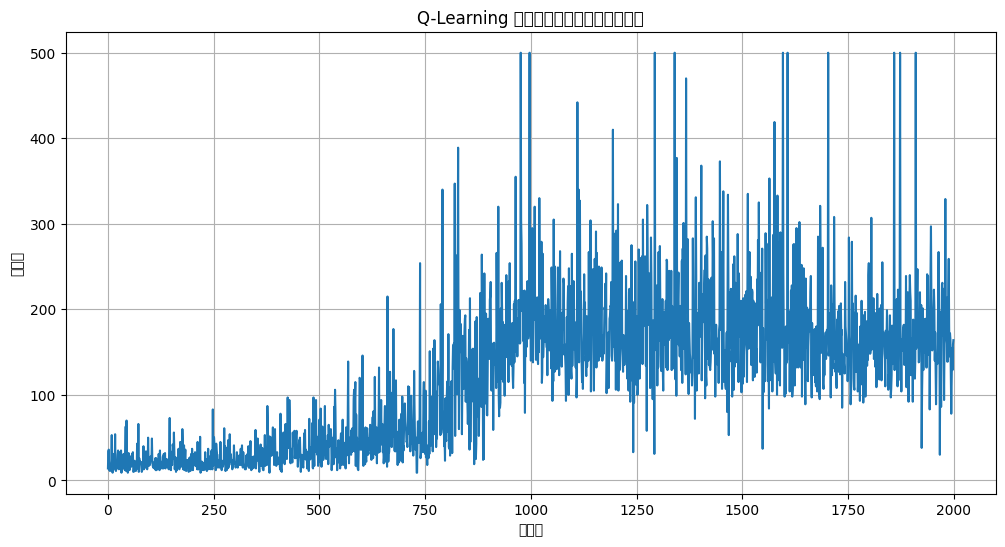

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  fig.canvas

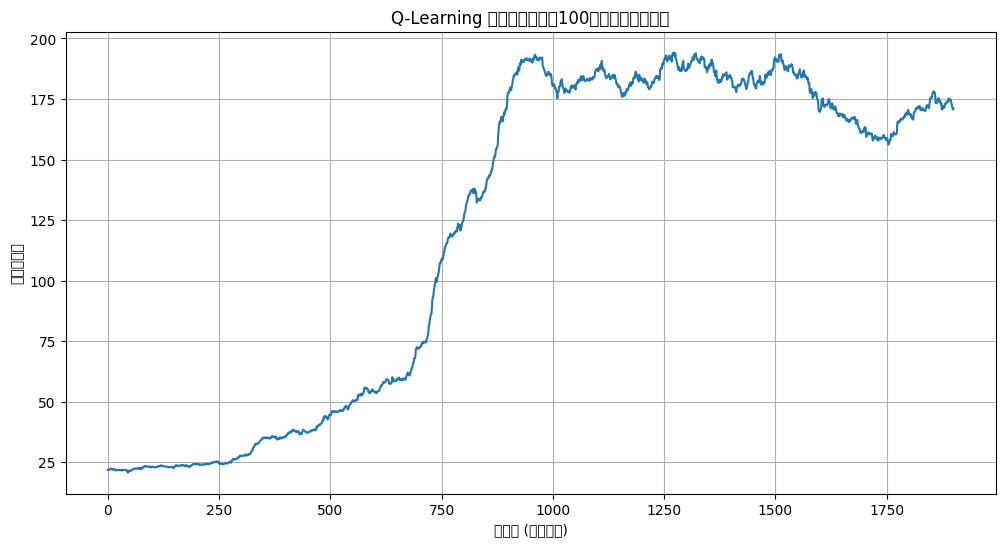

In [8]:
import matplotlib.pyplot as plt

# 绘制每个回合的总奖励
plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode)
plt.xlabel('回合数')
plt.ylabel('总奖励')
plt.title('Q-Learning 训练过程中每个回合的总奖励')
plt.grid(True)
plt.show()

# 绘制过去100个回合的平均奖励
moving_avg = np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid')
plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel('回合数 (滑动平均)')
plt.ylabel('平均总奖励')
plt.title('Q-Learning 训练过程中过去100个回合的平均奖励')
plt.grid(True)
plt.show()

### 6. 评估训练后的智能体

现在我们已经训练了一个 Q-Learning 智能体。让我们看看它在不进行探索的情况下（即 $\epsilon=0$）表现如何。

In [9]:
eval_env = gym.make('CartPole-v1', render_mode='rgb_array') # 使用 rgb_array 模式来捕获帧

num_eval_episodes = 5
rewards_eval = []

print("开始评估训练后的智能体...")
for episode in range(num_eval_episodes):
    observation, info = eval_env.reset()
    current_state = discretize_state(observation, n_bins, obv_space_low, obv_space_high)
    total_reward = 0
    frames = [] # 用于存储每一帧，如果需要生成视频

    for step in range(max_steps_per_episode):
        # 在评估时不进行探索，直接选择 Q 值最高的动作 (epsilon=0)
        action = choose_action(current_state, q_table, epsilon=0, action_space_size=action_space_size)

        new_observation, reward, terminated, truncated, info = eval_env.step(action)
        new_state = discretize_state(new_observation, n_bins, obv_space_low, obv_space_high)
        total_reward += reward

        # frames.append(eval_env.render())

        current_state = new_state

        if terminated or truncated:
            break
    rewards_eval.append(total_reward)
    print(f"评估回合 {episode + 1}/{num_eval_episodes}, 总奖励: {total_reward}")

eval_env.close()
print(f"平均评估奖励: {np.mean(rewards_eval)}")

开始评估训练后的智能体...
评估回合 1/5, 总奖励: 214.0
评估回合 2/5, 总奖励: 184.0
评估回合 3/5, 总奖励: 168.0
评估回合 4/5, 总奖励: 214.0
评估回合 5/5, 总奖励: 204.0
平均评估奖励: 196.8


### 总结

通过以上步骤，我们已经：

*   理解了 Q-Learning 的基本原理。
*   学会了如何对连续状态进行离散化。
*   实现了 Epsilon-Greedy 动作选择策略。
*   应用了 Q-Learning 的更新规则来训练智能体。
*   可视化了训练过程，并评估了训练后的智能体。

这只是强化学习的冰山一角。对于更复杂的环境和任务，您可能需要考虑深度强化学习（Deep Reinforcement Learning）算法，例如 DQN (Deep Q-Network)，它使用神经网络来近似 Q 函数，从而避免了状态离散化的问题。

### 接下来做什么？

这个简单的例子展示了如何与一个强化学习环境进行交互。要真正开始编写强化学习代码，您需要学习：

*   **状态空间（State Space）和动作空间（Action Space）**：理解环境的观测值和可以执行的动作。
*   **奖励函数（Reward Function）**：理解环境如何根据动作给予奖励。
*   **策略（Policy）**：智能体根据当前状态选择动作的规则。
*   **价值函数（Value Function）**：评估某个状态或某个状态-动作对的长期价值。

您可以开始尝试实现一些基础的强化学习算法，如Q-Learning、SARSA 或更复杂的深度强化学习算法 (DQN, PPO等)。